In [8]:
import os
os.environ['HF_HOME'] = "huggingface_home_directory/"

In [3]:
import torch
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# # You only need to run this once per machine
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U datasets scipy ipywidgets matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.4 requires absl-py>=0.4.0, which is not installed.
tensorflow 2.8.4 requires astunparse>=1.6.0, which is not installed.
tensorflow 2.8.4 requires flatbuffers>=1.12, which is not installed.
tensorflow 2.8.4 requires gast>=0.2.1, which is not installed.
tensorflow 2.8.4 requires google-pasta>=0.1.1, which is not installed.
tensorflow 2.8.4 requires keras<2.9,>=2.8.0rc0, which is not installed.
tensorflow 2.8.4 requires keras-preprocessing>=1.1.1, which is not installed.
tensorflow 2.8.4 requires libclang>=9.0.1, which is not installed.
tensorflow 2.8.4 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.8.4 requires tensorboard<2.9,>=2.8, which is not installed.
tensorflow 2.8.4 requires tensorflow-estimator<2.9,>=2.8, which is not installed.
tensorflow 2.8.4 requires tensorflow-io-gcs-fi

In [16]:
# main dataset -> lavita/ChatDoctor-HealthCareMagic-100k

In [4]:
from datasets import load_dataset, load_from_disk

dataset = load_from_disk("patients_query_sampled/")

train_dataset = dataset['train']
eval_dataset = dataset['test']

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 500
    })
})

### Formatting prompts

In [11]:
def formatting_func(example):
    text = f"### The following is a doctor's opinion on a person's query: \n### Patient query: {example['input']} \n### Doctor opinion: {example['output']}"
    return text

In [12]:
print(formatting_func(train_dataset[177]))

### The following is a doctor's opinion on a person's query: 
### Patient query: I have considerable lower back pain, also numbness in left buttocks and down left leg, girdling at the upper thigh.  MRI shows \"Small protrusiton of L3-4 interv. disc on left far laterally with annular fissuring fesulting in mild left neural foraminal narrowing with slight posterolateral displacement of the exiting l3 nerve root.\"  Other mild bulges L4-5 w/ fissuring, and mild buldge  L5-S1. 1) does this explain symptoms 2) I have a plane/car trip in 2 days lasting 8 hrs, then other travel.  Will this be harmful? 
### Doctor opinion: Hi, Your MRI report does explain your symptoms. Travelling is possible providing you take certain measures to make your journey as comfortable as possible. I suggest you ensure you take adequate supplies of your painkillers. When on the plane take every opportunity to move about the cabin to avoid sitting in the same position for too long. Likewise, when travelling by car, t

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, resume_download=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

5000


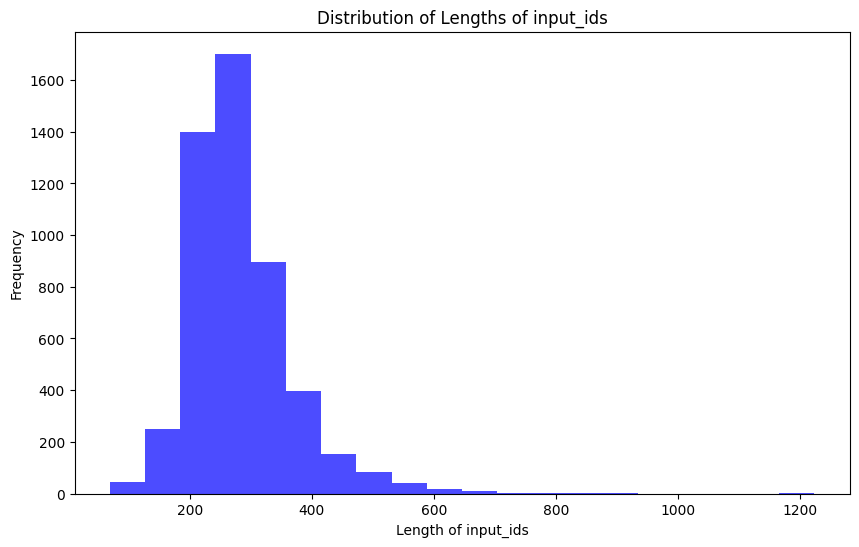

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [9]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [13]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 415, 2296, 349, 264, 511, 310, 783, 28742, 28713, 7382, 302, 264, 1338, 28742, 28713, 5709,

Now all the samples should be the same length, `max_length`.

5000


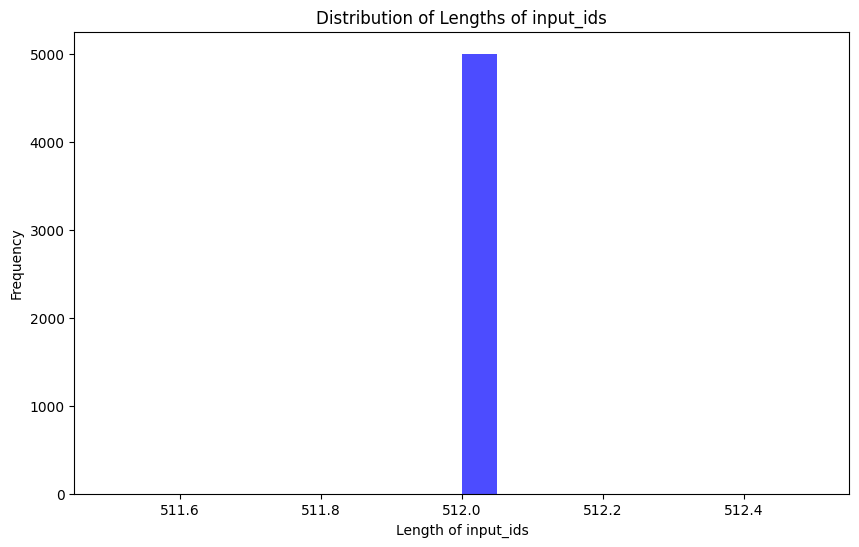

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

In [14]:
query = "Hi doc i am in the recovery after dengue, sometimes my heart feels like its rubbing with my chest and it feels very uncomfortable, what can be my problem?"
eval_prompt = """Patient's Query:\n\n {} ###\n\n""".format(query)

In [15]:
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Patient's Query:

 Hi doc i am in the recovery after dengue, sometimes my heart feels like its rubbing with my chest and it feels very uncomfortable, what can be my problem? ###

Dr. Suresh Reddy's Answer:

Dear Sir/Madam,

Thank you for your query. Dengue fever is a viral infection that causes flu-like symptoms such as high fever, headache, muscle pain, nausea, vomiting, swollen glands or rash. It is caused by any one of four closely related viruses transmitted by mosquitoes. The disease shares some clinical signs with other tropical diseases like malaria, typhoid and hepatitis.

The most common symptom of dengue fever is a sudden onset of high fever (104°F) accompanied by severe headaches, pain behind the eyes, muscle and joint pains, and a characteristic skin rash. Other symptoms include nausea, vomiting, swollen lymph nodes, mild bleeding from the nose or gums, bloodshot eyes, and easy bruising.

In rare cases, dengue fever may progress to dengue hemorrhagic fever (DHF), characteri

#### As you can see it gives some results but not something we are looking for!

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [11]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [13]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

### Accelerator

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [14]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [15]:
model = accelerator.prepare_model(model)

In [22]:
# !pip install -q wandb -U

# import wandb, os
# wandb.login()

# wandb_project = "journal-finetune"
# if len(wandb_project) > 0:
#     os.environ["WANDB_PROJECT"] = wandb_project

### 5. Run Training!

In [23]:
# if torch.cuda.device_count() > 1: # If more than 1 GPU
#     model.is_parallelizable = True
#     model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "chat-doctor-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-4, # Want a small lr for finetuning
        #bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train(resume_from_checkpoint=True)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
175,1.932700,1.951894
200,1.926000,1.944546
225,1.945500,1.935923
250,1.904500,1.927705
275,1.910900,1.919709
300,1.552600,1.966927
325,1.462200,1.960239
350,1.455700,1.968058
375,1.428200,1.959127
400,1.416300,1.965808


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-p

### Metrics

In [12]:
import json
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
train_checkpoints_data=json.load(open("mistral-patient-query-finetune/checkpoint-500/trainer_state.json")) 

In [11]:
lr = []
loss = []
eval_loss = []
steps=[]
for x in train_checkpoints_data['log_history']:
    try:
        lr.append(x['learning_rate'])
        loss.append(x['loss'])
        steps.append(x['step'])
    except:
        eval_loss.append(x['eval_loss'])

In [22]:
lr

[0.00023797595190380762,
 0.00022545090180360722,
 0.00021292585170340681,
 0.0002004008016032064,
 0.000187875751503006,
 0.00017535070140280563,
 0.0001628256513026052,
 0.00015030060120240483,
 0.0001377755511022044,
 0.000125250501002004,
 0.00011272545090180361,
 0.0001002004008016032,
 8.767535070140282e-05,
 7.515030060120241e-05,
 6.2625250501002e-05,
 5.01002004008016e-05,
 3.757515030060121e-05,
 2.50501002004008e-05,
 1.25250501002004e-05,
 0.0]

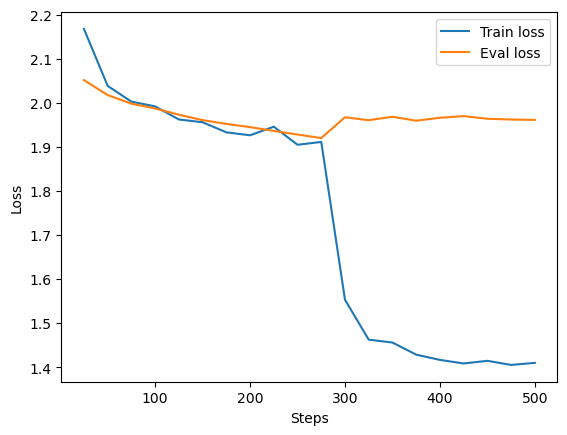

In [23]:
#plt.figure(figsize=(10,8))
plt.plot(steps, loss, label="Train loss")
plt.plot(steps, eval_loss, label= "Eval loss")
leg= plt.legend()
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

### Inference

In [9]:
import os
os.environ['HF_HOME'] = "huggingface_home_directory/"

In [2]:
import torch
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [5]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-patient-query-finetune/checkpoint-500/")

and run your inference!

In [14]:
print("Doc chat inference:")
print("===================================================================================")
query = " hi doc, my bmi is 28 what to do?"
eval_prompt = """Patient's Query: {} \n###\n\n""".format(query)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# ft_model.eval()
output = ft_model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=100, repetition_penalty=1.17)
# with torch.no_grad():

print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doc chat inference:
Patient's Query:  hi doc, my bmi is 28 what to do? 
###

Doctor Answer: Hello, I have studied your case. As per your BMI you are overweight and need to reduce weight. You can start with low calorie diet like green leafy vegetables, fruits, fish once a week, avoid meat and chicken. Avoid fried food and junk food. Do regular exercise for 45 minutes followed by weight training. You will see good results in 3 months time. Hope this answers your query. If you have additional questions or follow-up


In [7]:
print("Doc chat inference:")
print("===================================================================================")
query = " I had a 12 cm lump show up on my inner upper thigh almost overnight and have no idea what it may be.I know my immune system has been very much activated by all the alternative things I have been doing for my advanced prostate cancer and was thinking possibly dead cells and poisens looking for a another way to exit my body.Is this an absurd thought? ###"
eval_prompt = """Patient's Query:\n\n {} ###\n\n""".format(query)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# ft_model.eval()
output = ft_model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=100, repetition_penalty=1.15)
# with torch.no_grad():

print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doc chat inference:
Patient's Query:

  I had a 12 cm lump show up on my inner upper thigh almost overnight and have no idea what it may be.I know my immune system has been very much activated by all the alternative things I have been doing for my advanced prostate cancer and was thinking possibly dead cells and poisens looking for a another way to exit my body.Is this an absurd thought? ### ###

Doctor Answer: Hi, Thanks for your query. The lump in your upper thigh could be due to infection or inflammation of the lymph nodes. It is also possible that you might have developed some kind of tumor like lipoma or neurofibroma. You should consult a surgeon and get evaluated. If required, he can do fine needle aspiration cytology (FNAC) or biopsy of the lump to find out its cause. T


In [8]:
print("Doc chat inference:")
print("===================================================================================")
query = " hi doc chat i am suffering from Pulsation and pain at tempo region in head and sudden giddyness and pain, sometimes having vomiting sensation what can be my problem?"
eval_prompt = """Patient's Query:\n\n {} ###\n\n""".format(query)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# ft_model.eval()
output = ft_model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=100, repetition_penalty=1.15)
# with torch.no_grad():

print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doc chat inference:
Patient's Query:

  hi doc chat i am suffering from Pulsation and pain at tempo region in head and sudden giddyness and pain, sometimes having vomiting sensation what can be my problem? ###

Doctor Answer: Hello, Thanks for writing to Chat Doctor. I have gone through your query and understand your concern. As per your complaint you are having pulsation and pain at the temporal region of the head along with dizziness and vomiting sensation. This could be due to a condition called Migraine or Cluster Headache. You should take an appointment with your family physician and get evaluated. If required he may refer you to a neurologist for further evaluation. Meanwhile, you


In [15]:
print("Doc chat inference:")
print("===================================================================================")
query = " Hi doc chat i have been suffering from cough since last 15 days especially at night and also having breathing problem and slight fever, what can be my problem?"
eval_prompt = """Patient's Query:\n\n {} ###\n\n""".format(query)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# ft_model.eval()
output = ft_model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=100, repetition_penalty=1.15)
# with torch.no_grad():

print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doc chat inference:
Patient's Query:

  Hi doc chat i have been suffering from cough since last 15 days especially at night and also having breathing problem and slight fever, what can be my problem? ###

Doctor Answer: Thanks for your question on Chat Doctor. I can understand your concern. By your history and description, possibility of bronchitis is more likely. Bronchitis causes cough with sputum expectoration and breathing difficulty. So better to consult pulmonologist and get done clinical examination of respiratory system and PFT (Pulmonary Function Test).PFT will not only diagnose bronchitis, but it will also tell you about severity of the disease and


In [28]:
print("Doc chat inference:")
print("===================================================================================")
query = "Hi i am in the recovery after dengue, sometimes my heart feels like its rubbing with my chest and it feels very uncomfortable, what can be my problem?"
eval_prompt = """Patient's Query:\n\n {} ###\n\n""".format(query)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# ft_model.eval()
output = ft_model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=125, repetition_penalty=1.17)
# with torch.no_grad():

print(tokenizer.decode(output[0], skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doc chat inference:
Patient's Query:

 Hi i am in the recovery after dengue, sometimes my heart feels like its rubbing with my chest and it feels very uncomfortable, what can be my problem? ###

 Doctor Answer: Thanks for your question on Chat Doctor. I can understand your concern. Possibility of arrhythmia (rhythm disturbances in heart) is more likely in your case. Dengue infection can cause electrolyte imbalance which can lead to arrhythmias. So better to consult cardiologist and get done ECG, 2d echo and Holder monitoring (24 hour continuous recording of ECG). You may need anti arrhythmia Chat Doctor.  Don't worry, you will be alright. First diagnose yourself and then start appropriate treatment. Hope I have solved your


In [24]:
query="I have considerable lower back pain, also numbness in left buttocks and down left leg, girdling at the upper thigh.  MRI shows \"Small protrusiton of L3-4 interv. disc on left far laterally with annular fissuring fesulting in mild left neural foraminal narrowing with slight posterolateral displacement of the exiting l3 nerve root.\"  Other mild bulges L4-5 w/ fissuring, and mild buldge  L5-S1. 1) does this explain symptoms 2) I have a plane/car trip in 2 days lasting 8 hrs, then other travel.  Will this be harmful?"

print("Doc chat inference:")
print("===================================================================================")
eval_prompt = """Patient's Query:\n\n {} ###\n\n""".format(query)
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# ft_model.eval()
output = ft_model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=125, repetition_penalty=1.17)
# with torch.no_grad():

print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doc chat inference:
Patient's Query:

 I have considerable lower back pain, also numbness in left buttocks and down left leg, girdling at the upper thigh.  MRI shows "Small protrusiton of L3-4 interv. disc on left far laterally with annular fissuring fesulting in mild left neural foraminal narrowing with slight posterolateral displacement of the exiting l3 nerve root."  Other mild bulges L4-5 w/ fissuring, and mild buldge  L5-S1. 1) does this explain symptoms 2) I have a plane/car trip in 2 days lasting 8 hrs, then other travel.  Will this be harmful? ###

Doctor Answer: Hi, Thanks for your query. After going through your query I came to know that you are suffering from lumbar canal stenosis. It is due to compression of nerves exiting out of spinal cord due to disc herniation. You need to take neurosurgeon opinion regarding surgical decompression or conservative treatment. Till time, you can start pregabalin tablet under your doctors' guidance. Avoid long duration of standing. Sit in a

In [6]:
def respond(query):
    eval_prompt = """Patient's Query:\n\n {} ###\n\n""".format(query)
    model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
    output = ft_model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=125, repetition_penalty=1.15)
    result = tokenizer.decode(output[0], skip_special_tokens=True).replace(eval_prompt, "")
    return result

In [7]:
import random
import gradio as gr

def doc(message, history):
    return respond(message)

demo = gr.ChatInterface(random_response)

demo.launch()

Running on local URL:  http://127.0.0.1:7860
Sagemaker notebooks may require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://d1fd119b949f846b80.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
